# Introduction


## Problem statement


Singlife has observed a concerning trend in the customer journey: potential policyholders are expressing hesitation and eventual disengagement during the insurance acquisition process. To address this, Singlife seeks to leverage its dataset. The objective is to <font size="4">**derive actionable insights from this data to enhance the customer experience**</font>. The challenge is to dissect the dataset to <font size="4">**uncover the critical touchpoints that contribute to customer drop-off and identify opportunities to streamline the application process and personalize communication**</font>. The ultimate goal is to <font size="4">**predict customer satisfaction and conversion rates, thereby bolstering Singlife's market position**</font>.


## Selected variables


<strong><h5>1. General Client Information</h5></strong>

1. `clntnum`
2. `ctrycode_desc`
3. `stat_flag`
4. `min_occ_date`
5. `cltdob_fix`
6. `cltsex_fix`
7. `cltage` (Age of client)
8. `clt_ten` (Customer tenure)

<strong><h5>2. Client Risk and Status Indicators</h5></strong>

1. `flg_substandard`
2. `flg_is_borderline_standard`
3. `flg_is_revised_term`
4. `flg_has_health_claim`
5. `flg_gi_claim`
6. `flg_is_proposal`

<strong><h5>3. Demographic and Household Information</h5></strong>

1. `is_dependent_in_at_least_1_policy`
2. `annual_income_est`

<strong><h5>4. Policy and claim history</h5></strong>

1. `tot_inforce_pols`, `tot_cancel_pols`
2. `f_ever_declined_la`

<strong><h5>5. Target Column</h5></strong>

1. `f_purchase_lh` (Indicates if customer will purchase insurance in the next 3 months)


# Code


## Data cleaning


In [90]:
# The cell below is for you to keep track of the libraries used and install those libraries quickly
# Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

# %pip install pandas
# %pip install matplotlib
# %pip install pyarrow
# %pip install fastparquet
# %pip install seaborn
# %pip install scikit-learn
# %pip install tensorflow
# %pip install statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import tensorflow as tf
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from statsmodels.graphics.mosaicplot import mosaic
from collections import Counter
import pyarrow
import os
from datetime import datetime
currWD = os.getcwd()
print("Current Working Directory:", currWD)
# os.chdir("Enter working directory here")
filepath = "./data/catB_train.parquet"
data = pd.read_parquet(filepath, engine='pyarrow')
data_2 = data.copy()

In [58]:
import pickle

### **ALL** Code for machine learning and dataset analysis should be entered below.

##### Ensure that your code is clear and readable.

##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.


In [59]:
# Adding cltage and clt_ten cols
# Drop rows with incomplete data for `cltdob_fix`
data['cltdob_fix'] = data['cltdob_fix'].replace("None", pd.NaT)
cltdob_rows = data[data['cltdob_fix'].isna()]
data = data.dropna(subset=['cltdob_fix'])
# Drop rows with incomplete data for `min_occ_date`
data['min_occ_date'] = data['min_occ_date'].replace("None", pd.NaT)
occDate_rows = data[data['min_occ_date'].isna()]
data = data.dropna(subset=['min_occ_date'])

# Convert cltdob_fix to datetime format and compute the client's age
currentDate = datetime.now()
data["cltdob_fix"] = data["cltdob_fix"].map(
    lambda x: datetime.strptime(x, "%Y-%m-%d"))
data["cltage"] = data["cltdob_fix"].map(
    lambda x: ((currentDate - x).days/365.25))
# Convert min_occ_date to datetime format and compute cltage_start
data["min_occ_date"] = data["min_occ_date"].map(
    lambda x: datetime.strptime(x, "%Y-%m-%d"))
data["cltage_start"] = (
    (data["min_occ_date"] - data["cltdob_fix"]).dt.days/365.25).round().astype(int)

# Computing the customer tenure
data["clt_ten"] = data["cltage"] - data["cltage_start"]
# Adding back NA rows
data = pd.concat([data, cltdob_rows, occDate_rows], axis=0)
# Coverting NA to 0 for "f_purchase_lh" col
data["f_purchase_lh"] = np.where(data["f_purchase_lh"].isna(), 0, 1)
# Coverting NA to 0 for "is_dependent_in_at_least_1_policy" col
data["is_dependent_in_at_least_1_policy"] = np.where(
    data["is_dependent_in_at_least_1_policy"].isna(), 0, 1)

# Filtering columns
columnNames = ["clntnum", "ctrycode_desc", "stat_flag", "min_occ_date", "cltdob_fix", "cltsex_fix", "cltage", "clt_ten",
               "flg_substandard", "flg_is_borderline_standard", "flg_is_revised_term", "flg_has_health_claim", "flg_gi_claim", "flg_is_proposal",
               "is_dependent_in_at_least_1_policy", "annual_income_est", "tot_inforce_pols", "tot_cancel_pols", "f_ever_declined_la",
               "f_purchase_lh"]
data = data.loc[:, columnNames]

In [60]:
data_2['cltdob_fix'] = data_2['cltdob_fix'].replace("None", pd.NaT)
data_2['cltdob_fix'] = pd.to_datetime(data_2['cltdob_fix'])

data_2['min_occ_date'] = data_2['min_occ_date'].replace("None", pd.NaT)
data_2['min_occ_date'] = pd.to_datetime(data_2['min_occ_date'])


cltdob_rows = data_2[data_2['cltdob_fix'].isna()]
data_2 = data_2.dropna(subset=['cltdob_fix'])
# Drop rows with incomplete data_2 for `min_occ_date`
occDate_rows = data_2[data_2['min_occ_date'].isna()]
data_2 = data_2.dropna(subset=['min_occ_date'])

# Convert cltdob_fix to datetime format and compute the client's age
currentDate = datetime.now()
data_2["cltdob_fix"] = pd.to_datetime(data_2["cltdob_fix"])
data_2["cltage"] = data_2["cltdob_fix"].map(
    lambda x: ((currentDate - x).days/365.25))
# Convert min_occ_date to datetime format and compute cltage_start
data_2["min_occ_date"] = pd.to_datetime(data_2["min_occ_date"])
data_2["cltage_start"] = (
    (data_2["min_occ_date"] - data_2["cltdob_fix"]).dt.days/365.25).round().astype(int)

# Computing the customer tenure
data_2["clt_ten"] = data_2["cltage"] - data_2["cltage_start"]
# Adding back NA rows
data_2 = pd.concat([data_2, cltdob_rows, occDate_rows], axis=0)
# Coverting NA to 0 for "f_purchase_lh" col
data_2["f_purchase_lh"] = np.where(data_2["f_purchase_lh"].isna(), 0, 1)
# Coverting NA to 0 for "is_dependent_in_at_least_1_policy" col
data_2["is_dependent_in_at_least_1_policy"] = np.where(
    data_2["is_dependent_in_at_least_1_policy"].isna(), 0, 1)

#### Data modelling


In [61]:
dataColumns = data_2.dtypes[data_2.dtypes == object].index.to_list()
for x in dataColumns:
    try:
        data_2[x] = pd.to_numeric(data_2[x])
    except:
        data_2[x] = data_2[x]

# KNN Imputation for missing/ NA data
data_2.drop(columns=["clntnum"], inplace=True)
label_encoder = LabelEncoder()
data_2_cols = data_2.dtypes[data_2.dtypes ==
                            "object"].index.to_list()
data_2[data_2_cols] = data_2[data_2_cols].apply(
    lambda x: label_encoder.fit_transform(x))
# Perform KNN Imputation for columns with more than half of the data present and keep those columns only
incompleteCols = data_2.isna().sum()[data_2.isna().sum() > 17992/2]
incompleteCols = incompleteCols.index.to_list()
data_2.drop(columns=incompleteCols, inplace=True)

In [62]:
imputer = KNNImputer(n_neighbors=5)
data_2["min_occ_date"] = data_2["min_occ_date"].values.astype(
    "float64")
data_2["cltdob_fix"] = data_2["cltdob_fix"].values.astype("float64")
imputed_data_2 = imputer.fit_transform(data_2)
data_2 = pd.DataFrame(imputed_data_2, columns=imputer.get_feature_names_out())

In [63]:
# Resampling data
purchased_y = data_2["f_purchase_lh"]
data_2_set_1 = data_2.drop(columns=['f_purchase_lh'])

oversample = SMOTE(sampling_strategy=0.1)
undersample = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', oversample), ('u', undersample)]
pipeline = Pipeline(steps=steps)

counter = Counter(purchased_y)
print(counter)
data_2_set_1, purchased_y = pipeline.fit_resample(data_2_set_1, purchased_y)
counter = Counter(purchased_y)
print(counter)

Counter({0.0: 17282, 1.0: 710})
Counter({0.0: 3456, 1.0: 1728})


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn import metrics

# Passing the resampled data into different models
X_train, X_val, y_train, y_val = train_test_split(
    data_2_set_1, purchased_y, test_size=0.2, random_state=0)


def RFE_and_model_evaluation(model):
    min_features_to_select = 1  # Minimum number of features to consider
    clf = model
    cv = StratifiedKFold(5)
    #    cv = RepeatedStratifiedKFold(random_state = 5)

    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="f1_macro",
        min_features_to_select=min_features_to_select,
        n_jobs=2,
    )
    rfecv.fit(X_train, y_train)

    print(f"Optimal number of features: {rfecv.n_features_}")
    print(rfecv.get_feature_names_out())
    print(rfecv.score(X_val, y_val))
    return rfecv

In [29]:
# Training on the Logistic Regession Model
# logmodel = RFE_and_model_evaluation(LogisticRegression())
# dectreemodel = RFE_and_model_evaluation(DecisionTreeClassifier())
# randoforest = RFE_and_model_evaluation(RandomForestClassifier())

logmodel_file = "logistic_regression_model.pkl"
dectree_file = "decision_tree_classifier_model.pkl"
randoforest_file = "random_forest_classifier_model.pkl"

with open("logistic_regression_model.pkl", 'rb') as file:
    logmodel = pickle.load(file)
with open("decision_tree_classifier_model.pkl", 'rb') as file:
    dectreemodel = pickle.load(file)
with open("random_forest_classifier_model.pkl", 'rb') as file:
    randoforest = pickle.load(file)

In [66]:
print(logmodel.get_feature_names_out())
print(logmodel.score(X_val, y_val))

['min_occ_date' 'cltdob_fix']
0.6586306653809064


In [67]:
print(dectreemodel.get_feature_names_out())
print(dectreemodel.score(X_val, y_val))

['min_occ_date' 'cltdob_fix' 'cltsex_fix' 'is_consent_to_mail'
 'is_consent_to_email' 'is_valid_dm' 'is_class_1_2'
 'is_dependent_in_at_least_1_policy' 'hh_20' 'pop_20' 'hh_size'
 'hh_size_est' 'annual_income_est' 'n_months_last_bought_products'
 'tot_inforce_pols' 'ape_lh_f852af' 'sumins_ltc' 'sumins_507c37'
 'prempaid_e22a6a' 'prempaid_ltc' 'f_ever_bought_839f8a'
 'n_months_last_bought_e22a6a' 'n_months_last_bought_507c37'
 'n_months_last_bought_gi' 'n_months_last_bought_grp_1581d7'
 'n_months_last_bought_lh_e22a6a' 'n_months_last_bought_32c74c' 'f_retail'
 'cltage' 'cltage_start' 'clt_ten']
0.8351012536162006


In [68]:
# Training on the Decision Tree Model
print(randoforest.get_feature_names_out())
print(randoforest.score(X_val, y_val))

['race_desc' 'clttype' 'min_occ_date' 'cltdob_fix' 'cltsex_fix'
 'flg_substandard' 'flg_gi_claim' 'is_consent_to_mail'
 'is_consent_to_email' 'is_consent_to_call' 'is_consent_to_sms'
 'is_valid_dm' 'is_valid_email' 'is_housewife_retiree' 'is_class_1_2'
 'is_dependent_in_at_least_1_policy' 'hh_20' 'pop_20' 'hh_size'
 'hh_size_est' 'annual_income_est' 'n_months_last_bought_products'
 'flg_latest_being_lapse' 'tot_inforce_pols' 'ape_ltc_43b9d5'
 'ape_grp_1581d7' 'ape_lh_e22a6a' 'ape_grp_70e1dd' 'ape_lh_f852af'
 'ape_lh_947b15' 'sumins_ltc_43b9d5' 'sumins_grp_1581d7'
 'sumins_grp_70e1dd' 'sumins_lh_f852af' 'sumins_lh_947b15'
 'prempaid_ltc_43b9d5' 'prempaid_grp_1581d7' 'prempaid_lh_e22a6a'
 'prempaid_grp_70e1dd' 'prempaid_lh_f852af' 'prempaid_lh_947b15'
 'ape_839f8a' 'ape_e22a6a' 'ape_ltc' 'ape_507c37' 'f_hold_839f8a'
 'f_hold_e22a6a' 'f_hold_507c37' 'sumins_839f8a' 'sumins_ltc'
 'sumins_507c37' 'prempaid_839f8a' 'prempaid_e22a6a' 'prempaid_ltc'
 'prempaid_507c37' 'f_ever_bought_839f8a' 'f

In [69]:
pd.DataFrame(dectreemodel.estimator_.feature_importances_,
             index=dectreemodel.get_feature_names_out(), columns=["Gini Importance"])

,Gini Importance
min_occ_date,0.018635
cltdob_fix,0.023404
cltsex_fix,0.024582
is_consent_to_mail,0.024246
is_consent_to_email,0.010918
is_valid_dm,0.013530
is_class_1_2,0.041380
is_dependent_in_at_least_1_policy,0.010189
hh_20,0.022112
pop_20,0.035182


In [70]:
pd.DataFrame(randoforest.estimator_.feature_importances_,
             index=randoforest.get_feature_names_out(), columns=["Gini Importance"])

,Gini Importance
race_desc,0.011779
clttype,0.004692
min_occ_date,0.021377
cltdob_fix,0.022683
cltsex_fix,0.014127
...,...
f_mindef_mha,0.002236
f_retail,0.007059
cltage,0.023067
cltage_start,0.019103


In [71]:
logmodel_file = "logistic_regression_model.pkl"
dectree_file = "decision_tree_classifier_model.pkl"
randoforest_file = "random_forest_classifier_model.pkl"

with open(logmodel_file, 'wb') as file:
    pickle.dump(logmodel, file)

with open(dectree_file, 'wb') as file:
    pickle.dump(dectreemodel, file)

with open(randoforest_file, 'wb') as file:
    pickle.dump(randoforest, file)

In [72]:
# Data modelling
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
unique1 = data["flg_is_proposal"].unique()
unique2 = data["f_purchase_lh"].unique()

na1 = data["flg_is_proposal"].isna().sum()
na2 = data["f_purchase_lh"].isna().sum()

colns = ["flg_is_proposal", "f_purchase_lh"]
# those that have NA values become 0 instead
data[colns] = data[colns].fillna(0)

data['conversion'] = np.where((data["flg_is_proposal"] == 1) & (
    data["f_purchase_lh"] == 1), True, False)

# Convert income est from string to integers instead
income_mapping = {
    'D.30K-60K': 45000,
    'E.BELOW30K': 30000,
    'A.ABOVE200K': 200000,
    'C.60K-100K': 80000,
    'B.100K-200K': 150000
}

data_modelling = data.copy()
data_modelling["annual_income_est"] = data_modelling["annual_income_est"].replace(
    income_mapping)
cleaned_df = data_modelling.dropna(subset=['annual_income_est', 'cltage'])


X = cleaned_df[["annual_income_est", "cltage"]]
Y = cleaned_df['conversion']

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)


def train_model(X_train, y_train):
    """
    Train a logistic regression model using the provided training data.

    Parameters:
    - X_train: Features of the training dataset.
    - y_train: Labels of the training dataset.

    Returns:
    - model: Trained logistic regression model.
    """

    # Train the logistic regression model
    logistic_reg_model = LogisticRegression()
    logistic_reg_model.fit(X_train, y_train)

    return logistic_reg_model

#### Data Analysis


In [73]:
# Filter the data for clients who are no longer active in SingLife
df_inactive = data[data['stat_flag'] != 'ACTIVE']
selected_colns = ["flg_substandard", "flg_is_borderline_standard", "flg_is_revised_term", "is_dependent_in_at_least_1_policy", "annual_income_est", "tot_inforce_pols", "tot_cancel_pols", "f_ever_declined_la",
                  "f_purchase_lh"]
df_inactive = df_inactive.loc[:, selected_colns]

# Checking total number of NAs for each column

inforce_na = df_inactive['tot_inforce_pols'].isna().sum()
cancelled_na = df_inactive['tot_cancel_pols'].isna().sum()
declined_na = df_inactive["f_ever_declined_la"].isna().sum()
purchased_na = df_inactive["f_purchase_lh"].isna().sum()

# print(inforce_na), print(cancelled_na), print(declined_na), print(purchased_na)

# Replace NA values with 0 in the selected columns
colns_to_fill = ["tot_inforce_pols", "tot_cancel_pols",
                 "f_ever_declined_la", "f_purchase_lh"]
df_inactive[colns_to_fill] = df_inactive[colns_to_fill].fillna(0)

income_mapping = {
    'D.30K-60K': 45000,
    'E.BELOW30K': 30000,
    'A.ABOVE200K': 200000,
    'C.60K-100K': 80000,
    'B.100K-200K': 150000
}

df_inactive["annual_income_est"] = df_inactive["annual_income_est"].replace(
    income_mapping)

colns_1 = ["annual_income_est", "tot_cancel_pols"]
colns_2 = ["annual_income_est", 'f_ever_declined_la']
colns_3 = ["annual_income_est", "f_purchase_lh"]
df4 = df_inactive.loc[:, colns_1].dropna()
df5 = df_inactive.loc[:, colns_2].dropna()
df6 = df_inactive.loc[:, colns_3].dropna()

# checking income and correlation with cancellation history
print(df4.dtypes)
r1 = df4["annual_income_est"].corr(df4["tot_cancel_pols"])
print(r1)

# checking income and correlation with purchase inclination
r2 = df6["annual_income_est"].corr(df6["f_purchase_lh"])
print(r2)

# checking income and correlation with declined history
r3 = df5["annual_income_est"].corr(df5["f_ever_declined_la"])
print(r3)
# print(df4["annual_income_est"].unique())

annual_income_est    float64
tot_cancel_pols      float64
dtype: object
-0.025193474157386545
0.0038959791232433066
0.050437166109267725


In [74]:
# Filtering for the identified columns
colNames_set_1 = ["flg_has_health_claim", "flg_gi_claim", "is_dependent_in_at_least_1_policy",
                  "tot_inforce_pols", "annual_income_est", "f_purchase_lh", "tot_cancel_pols", "cltage", "clt_ten",
                  "flg_is_proposal"]
data_set_1 = data.loc[:, colNames_set_1]

# Perform imputation for missing data
data_set_1['annual_income_est'] = label_encoder.fit_transform(
    data_set_1['annual_income_est'])
imputed_data_set_1 = imputer.fit_transform(data_set_1)
data_set_1 = pd.DataFrame(imputed_data_set_1, columns=data_set_1.columns)

In [75]:
itemDict = {}

for category, encoded_value in zip(data['annual_income_est'], data_set_1['annual_income_est']):
    newItem = f"{encoded_value} {category}"
    if newItem not in itemDict:
        itemDict[newItem] = 0

print("Levels:")
for x in sorted(list(itemDict)):
    print(x)

Levels:
0.0 A.ABOVE200K
1.0 B.100K-200K
2.0 C.60K-100K
3.0 D.30K-60K
4.0 E.BELOW30K
5.0 None


In [76]:
# Clean up data from imputer
data_set_1["flg_has_health_claim"] = np.where(
    data_set_1["flg_has_health_claim"] < 0.5, 0, 1)

data_set_1["flg_gi_claim"] = np.where(
    data_set_1["flg_gi_claim"] < 0.5, 0, 1)

data_set_1["flg_is_proposal"] = np.where(
    data_set_1["flg_is_proposal"] < 0.5, 0, 1)

data_set_1["tot_inforce_pols"] = data_set_1["tot_inforce_pols"].astype(int)

data_set_1["is_dependent_in_at_least_1_policy"] = np.where(
    data_set_1["is_dependent_in_at_least_1_policy"] < 0.5, 0, 1)

data_set_1["annual_income_est"] = pd.Categorical(
    data_set_1["annual_income_est"].map({
        0: "Above 200K",
        1: "100K-200K",
        2: "60K-100K",
        3: "30K-60K",
        4: "Below 30K",
    })
).set_categories(["Below 30K", "30K-60K", "60K-100K", "100K-200K", "Above 200K"], ordered=True)

data_set_1["f_purchase_lh"] = np.where(
    data_set_1["f_purchase_lh"] < 0.5, 0, 1)

data_set_1["tot_cancel_pols"] = data_set_1["tot_cancel_pols"].astype(int)

data_set_1["cltage"] = data_set_1["cltage"].astype(int)

data_set_1["clt_ten"] = data_set_1["clt_ten"].astype(int)

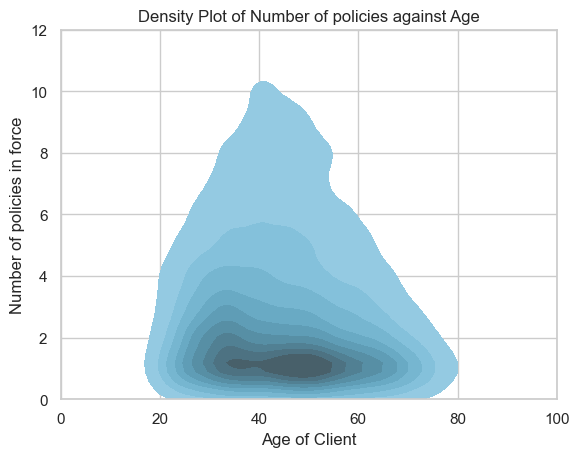

In [77]:
# Density Plot of Number of policies against Age
sns.set(style="whitegrid")
sns.kdeplot(x=data_set_1["cltage"],
            y=data_set_1["tot_inforce_pols"], fill=True, color="skyblue")
plt.xlim(0, 100)
plt.ylim(0, 12)
plt.xlabel("Age of Client")
plt.ylabel("Number of policies in force")
plt.title("Density Plot of Number of policies against Age")
plt.show()

From the density plot, we can observe that a large concentration of clients belong to the 30-60 years old age group and they mostly have 1 policy in force


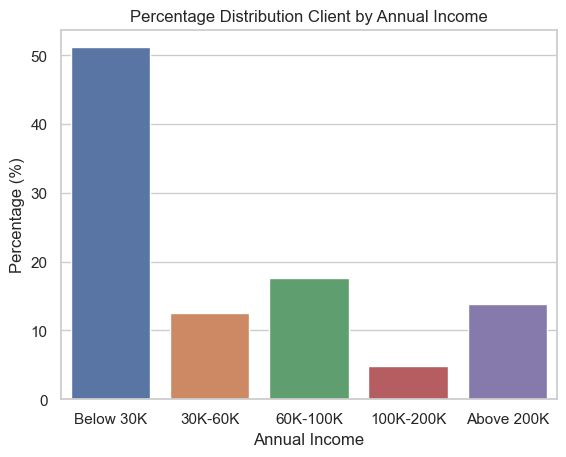

In [78]:
# Bar plot of Client count based on income
percentageIncome = data_set_1['annual_income_est'].value_counts(
    normalize=True) * 100

sns.barplot(x=percentageIncome.index, y=percentageIncome.values)

plt.xlabel('Annual Income')
plt.ylabel('Percentage (%)')
plt.title('Percentage Distribution Client by Annual Income')
plt.show()

As we can see from the bar plot, A large majority of clients also belong to the Below 30K income group. Therefore, it might be easier to target and persuade clients from this income group who are between 30 to 60 years old to sign up for a policy.


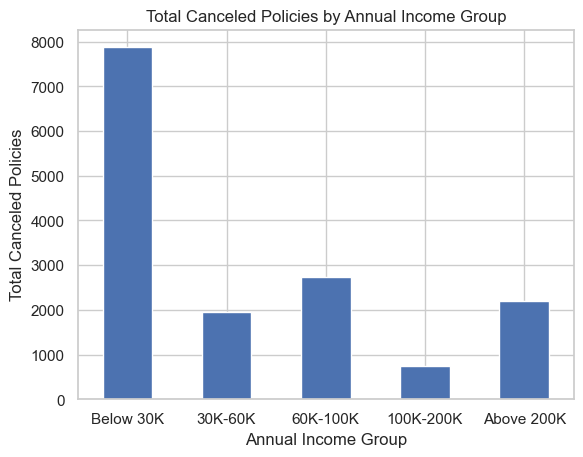

In [79]:
sum_by_income_group = data_set_1.groupby('annual_income_est')[
    'tot_cancel_pols'].sum()

# Plot the result as a bar plot
sum_by_income_group.plot(kind='bar')

# Customize plot labels and title
plt.xlabel('Annual Income Group')
plt.ylabel('Total Canceled Policies')
plt.title('Total Canceled Policies by Annual Income Group')
plt.xticks(rotation=0)

plt.show()

Although a large number of clients belong to the Below 30K annual income group, they also have the highest cancellation count. To investigate further, we can visualise the cancellation rate for each income group.


In [80]:
# Rate of Policy Cancellation by Income Group
cilentCountByIncome = data_set_1['annual_income_est'].value_counts()
cancellationSum_by_income_group = data_set_1.groupby('annual_income_est')[
    'tot_cancel_pols'].sum()

cancellation_rate_by_income = (
    cancellationSum_by_income_group / cilentCountByIncome)

print(cancellation_rate_by_income)

Below 30K     1.012997
30K-60K       1.016222
60K-100K      1.021650
100K-200K     1.031724
Above 200K    1.044349
dtype: float64


As seen from the table, the cancellation rate between all income groups are seen to be approximately the same. This means that it would be better to find clients that belong to the Under 30K income group, and are between 30 to 60 years old as they are more likely to sign up for the policy according to the data.

To further support this relationship, we can plot a density plot and find out the ages of clients who are more likely to cancel their policy as the sign ups by clients aged 30 to 60 years old might also be the ones who cancel their policy.


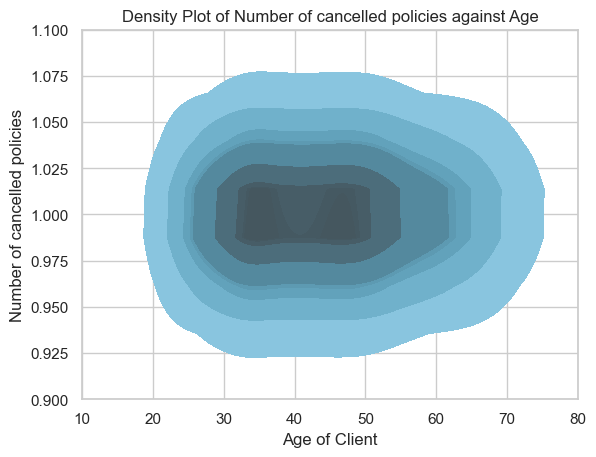

In [81]:
# Density Plot of Number of policies against Age
sns.set(style="whitegrid")
sns.kdeplot(x=data_set_1["cltage"],
            y=data_set_1["tot_cancel_pols"], fill=True, color="skyblue")
plt.xlim(10, 80)
plt.ylim(0.9, 1.1)
plt.xlabel("Age of Client")
plt.ylabel("Number of cancelled policies")
plt.title("Density Plot of Number of cancelled policies against Age")
plt.show()

From this density plot, we can see that clients who are more likely to cancel their policy are between 32 to 50. Since we have found that those between 40 to 60 years old are most likely to sign up, from our new findings, we can further narrow down this age group to 50 to 60 years old. As the client ages, we can also see that they would be more unlikely to cancel their policy, allowing the company to retain more clients in the long run. However, since the number of policies signed up by those between 32 to 50 have a larger range with a maximum of 10 policies, it outweights the number of cancelled policies by that age group of 1.

Therefore, finding clients that belong to the Under 30K income group, and are between 50 to 60 years old are more likely to sign up for the policy without cancelling it while those with an income of Under 30K and are between 32 to 50 are more likely to sign for more policies while cancelling an estimated of 1 policy. This means that those between 32 and 50 will still have a policy inforce.


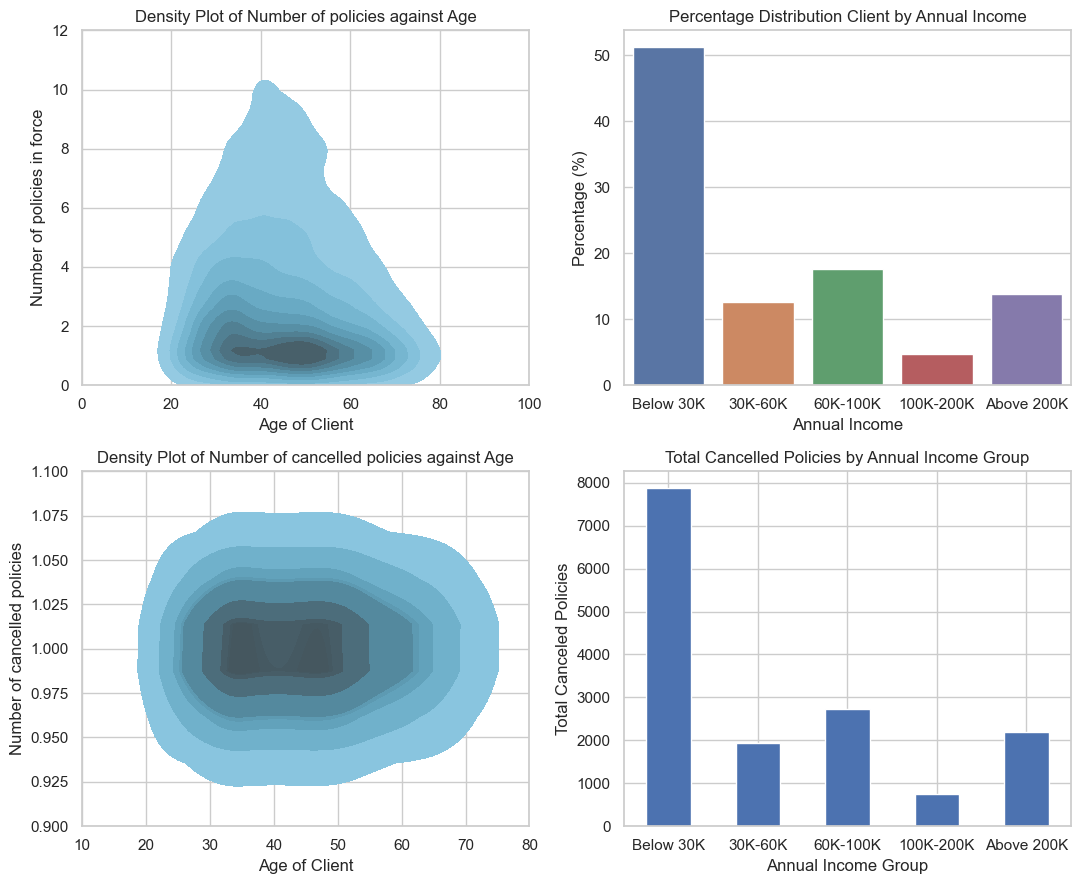

In [82]:
fig, axes = plt.subplots(2, 2, figsize=(11, 9))

# Density Plot of Number of policies against Age
sns.kdeplot(x=data_set_1["cltage"], y=data_set_1["tot_inforce_pols"],
            fill=True, color="skyblue", ax=axes[0, 0])
axes[0, 0].set_xlim(0, 100)
axes[0, 0].set_ylim(0, 12)
axes[0, 0].set_xlabel("Age of Client")
axes[0, 0].set_ylabel("Number of policies in force")
axes[0, 0].set_title("Density Plot of Number of policies against Age")

# Bar plot of Client count based on income
percentageIncome = data_set_1['annual_income_est'].value_counts(
    normalize=True) * 100
sns.barplot(x=percentageIncome.index, y=percentageIncome.values, ax=axes[0, 1])
axes[0, 1].set_xlabel('Annual Income')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].set_title('Percentage Distribution Client by Annual Income')

# Density Plot of Number of Total Cancelled policies against Age
sns.kdeplot(x=data_set_1["cltage"], y=data_set_1["tot_cancel_pols"],
            fill=True, color="skyblue", ax=axes[1, 0])
axes[1, 0].set_xlim(10, 80)
axes[1, 0].set_ylim(0.9, 1.1)
axes[1, 0].set_xlabel("Age of Client")
axes[1, 0].set_ylabel("Number of cancelled policies")
axes[1, 0].set_title(
    "Density Plot of Number of cancelled policies against Age")

# Bar plot of Total Cancelled Policies by Annual Income Group
sum_by_income_group = data_set_1.groupby('annual_income_est')[
    'tot_cancel_pols'].sum()
sum_by_income_group.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_xlabel('Annual Income Group')
axes[1, 1].set_ylabel('Total Canceled Policies')
axes[1, 1].set_title('Total Cancelled Policies by Annual Income Group')
axes[1, 1].tick_params(rotation=0)

plt.tight_layout()
plt.show()

In [83]:
# Splitting the clients up based on those that is going to purchase a policy and those undecided
satisfiedClients = data_set_1[data_set_1["f_purchase_lh"] == 1]
moodClients = data_set_1[data_set_1["f_purchase_lh"] != 1]
# Selecting potentially useful variables for analysis
satisfiedClients = satisfiedClients[["tot_inforce_pols", "cltage",
                                    "clt_ten", "tot_cancel_pols", "flg_gi_claim", "flg_has_health_claim"]]
moodClients = moodClients[["tot_inforce_pols", "cltage", "clt_ten",
                          "tot_cancel_pols", "flg_gi_claim", "flg_has_health_claim"]]

Next, we compare the 2 groups of clients. Those that are going to purchase a policy within the next 3 months and those that are not. We assume that those who are purchasing are satisfied and those who are not may not be satisfied.

By plotting 2 heatmaps and compare the difference between the 2 groups and identify the potential variables that could have an influence on in individuals decision making.


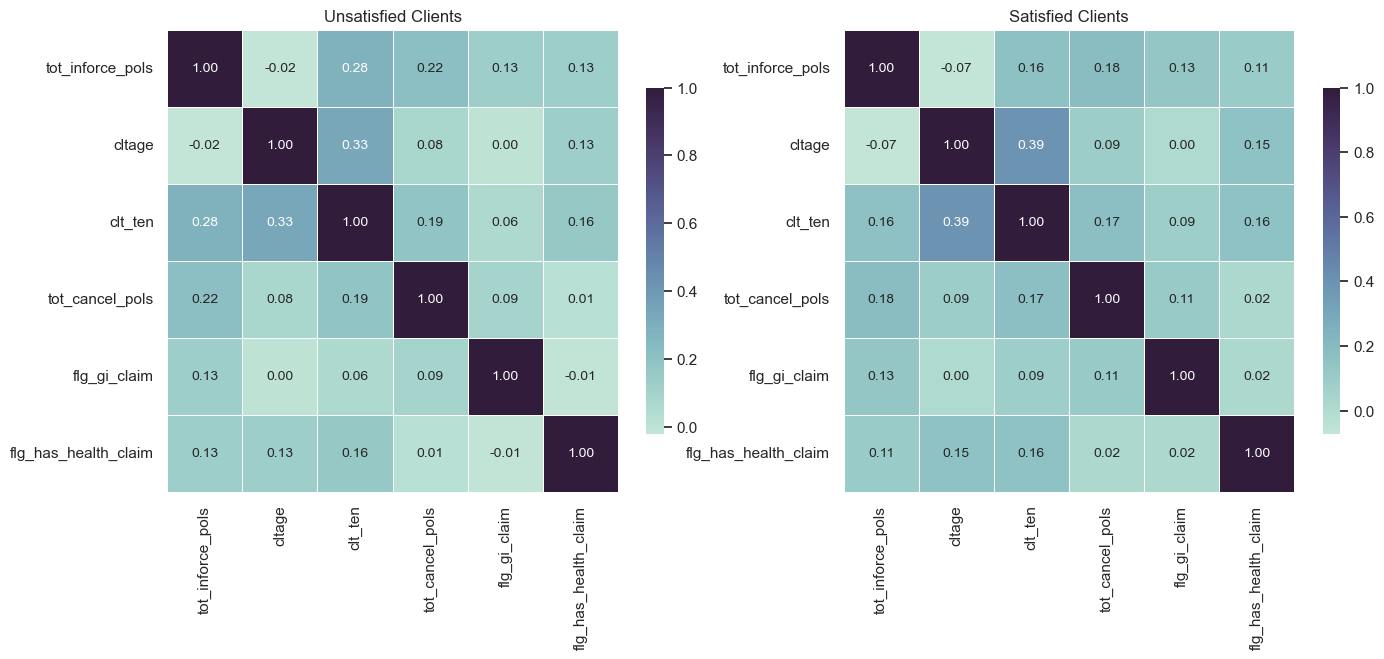

In [84]:
# Setting up the heatmap for comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sat = satisfiedClients.corr()
sns.heatmap(sat, annot=True, cmap=sns.cubehelix_palette(
    start=.5, rot=-.5, as_cmap=True), ax=axes[0], fmt=".2f", linewidths=.5, annot_kws={"size": 10}, cbar_kws={"shrink": 0.75})
axes[0].set_title('Unsatisfied Clients')
mood = moodClients.corr()
sns.heatmap(mood, annot=True, cmap=sns.cubehelix_palette(
    start=.5, rot=-.5, as_cmap=True), ax=axes[1], fmt=".2f", linewidths=.5, annot_kws={"size": 10}, cbar_kws={"shrink": 0.75})
axes[1].set_title('Satisfied Clients')

plt.show()

However upon analysis, we find it difficult to compare with the current variables used as there is no significant difference between the 2 groups


## The cell below is **NOT** to be removed

##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list).

##### It is recommended to test the function out prior to submission

---

##### The hidden*data parsed into the function below will have the same layout columns wise as the dataset \_SENT* to you

##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below


In [85]:
# test model for conversion rate based on age group and income group

def testing_hidden_data(hidden_data: pd.DataFrame, trained_model) -> list:

    # Preprocess the hidden data
    hidden_data['cltdob_fix'] = hidden_data['cltdob_fix'].replace(
        "None", pd.NaT)
    cltdob_rows = hidden_data[hidden_data['cltdob_fix'].isna()]
    hidden_data = hidden_data.dropna(subset=['cltdob_fix'])

    hidden_data['min_occ_date'] = hidden_data['min_occ_date'].replace(
        "None", pd.NaT)
    occDate_rows = hidden_data[hidden_data['min_occ_date'].isna()]
    hidden_data = hidden_data.dropna(subset=['min_occ_date'])

    # Calculate cltage from cltdob_fix and min_occ_date
    hidden_data['cltage'] = (
        hidden_data['min_occ_date'] - hidden_data['cltdob_fix']).dt.days // 365

    # Drop irrelevant columns
    hidden_data = hidden_data.drop(['cltdob_fix', 'min_occ_date'], axis=1)

    # Preprocess the remaining data
    hidden_data["annual_income_est"] = hidden_data["annual_income_est"].replace(
        income_mapping)
    cleaned_hidden_data = hidden_data.dropna(
        subset=['annual_income_est', 'cltage'])

    # Extract features and labels
    X_hidden = cleaned_hidden_data[["annual_income_est", "cltage"]]

    # Predict using the trained model
    hidden_predictions = trained_model.predict(X_hidden)

    return hidden_predictions

##### Cell to check testing_hidden_data function


In [89]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!
